In [1]:
import pandas as pd
import numpy as np
import re
import json
import matplotlib.pyplot as plt

In [2]:
results = pd.read_csv('results.csv')[['Round', 'Home', 'Away', 'Score']].set_index(['Home', 'Away'])
fivethirtyeight = pd.read_csv('538.csv').rename(columns={
    'proba': '538_proba',
    'probx': '538_probx',
    'probb': '538_probb',
})
fivethirtyeight['teama'] = fivethirtyeight['teama'].apply(lambda x: x if x != 'USA' else 'United States')
fivethirtyeight['teamb'] = fivethirtyeight['teamb'].apply(lambda x: x if x != 'USA' else 'United States')
fivethirtyeight['teama'] = fivethirtyeight['teama'].apply(lambda x: x if x != 'South Korea' else 'Korea Republic')
fivethirtyeight['teamb'] = fivethirtyeight['teamb'].apply(lambda x: x if x != 'South Korea' else 'Korea Republic')
fivethirtyeight = fivethirtyeight.rename(columns={'teama': 'Home', 'teamb': 'Away'}).set_index(['Home', 'Away'])
m301060 = pd.read_csv('301060.csv')
m301060.columns = ['proba', 'Home', 'probx', 'Away', 'probb']
m301060['proba'] /= 100
m301060['probx'] /= 100
m301060['probb'] /= 100
m301060 = m301060.rename(columns={
    'proba': '301060_proba',
    'probx': '301060_probx',
    'probb': '301060_probb',
}).set_index(['Home', 'Away'])
names = {
    'Qatar': 'qat',
    'Ecuador': 'ecu',
    'England': 'eng',
    'Senegal': 'sen',
    'United States': 'usa',
    'Argentina': 'arg',
    'Denmark': 'den',
    'Mexico': 'mex',
    'France': 'fra',
    'Morocco': 'mor',
    'Germany': 'ger',
    'Spain': 'spa',
    'Belgium': 'bel',
    'Switzerland': 'swi',
    'Uruguay': 'uru',
    'Portugal': 'por',
    'Brazil': 'bra',
    'Wales': 'wal',
    'Netherlands': 'ned',
    'Tunisia': 'tun',
    'Poland': 'pol',
    'Japan': 'jap',
    'Croatia': 'cro',
    'Cameroon': 'cam',
    'Korea Republic': 'kor',
    'Ecuador': 'ecu',
    'Iran': 'ira',
    'Australia': 'aus',
    'Saudi Arabia': 'sau',
    'Canada': 'can',
    'Costa Rica': 'cos',
    'Ghana': 'gha',
    'Serbia': 'ser',
}

def read_oddspedia(f):
    with open(f'oddspedia/{f}.json', 'r') as fp:
        data = json.loads(fp.read())['data']['prematch'][0]['periods'][0]['odds']
    series = {}
    for row in data:
        if row['bookie_slug'] != 'bet365': continue
        p1, p2, p3 = 1/float(row['o1']), 1/float(row['o2']), 1/float(row['o3'])
        series[f'{row["bookie_slug"]}_proba'] = p1/(p1+p2+p3)
        series[f'{row["bookie_slug"]}_probx'] = p2/(p1+p2+p3)
        series[f'{row["bookie_slug"]}_probb'] = p3/(p1+p2+p3)
        series[f'{row["bookie_slug"]}_paya'] = float(row['o1'])
        series[f'{row["bookie_slug"]}_payx'] = float(row['o2'])
        series[f'{row["bookie_slug"]}_payb'] = float(row['o3'])
    return pd.Series(series)

oddspedia = results.apply(lambda row: read_oddspedia(f'{names[row.name[0]]}-{names[row.name[1]]}'), axis=1)
df = results.join(fivethirtyeight).join(m301060).join(oddspedia.dropna(axis=1)).reset_index()
df = df.drop([62, 63]).set_index(['Home', 'Away'])
df

,,Round,Score,538_proba,538_probx,538_probb,301060_proba,301060_probx,301060_probb,bet365_proba,bet365_probx,bet365_probb,bet365_paya,bet365_payx,bet365_payb
Home,Away,,,,,,,,,,,,,,
Qatar,Ecuador,Group stage,0–2,0.24,0.26,0.50,0.13,0.21,0.66,0.263158,0.315789,0.421053,3.60,3.00,2.250
England,Iran,Group stage,6–2,0.63,0.25,0.12,0.68,0.20,0.12,0.695688,0.199186,0.105126,1.36,4.75,9.000
Senegal,Netherlands,Group stage,0–2,0.22,0.27,0.51,0.15,0.21,0.64,0.171203,0.261560,0.567238,5.50,3.60,1.660
United States,Wales,Group stage,1–1,0.45,0.29,0.26,0.47,0.29,0.23,0.391244,0.309209,0.299546,2.45,3.10,3.200
Argentina,Saudi Arabia,Group stage,1–2,0.72,0.20,0.08,0.79,0.15,0.05,0.848285,0.110776,0.040939,1.11,8.50,23.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Netherlands,Argentina,Quarter-finals,(3) 2–2 (4),0.42,0.00,0.58,0.28,0.24,0.48,0.263320,0.305792,0.430888,3.60,3.10,2.200
Morocco,Portugal,Quarter-finals,1–0,0.32,0.00,0.68,0.30,0.29,0.40,0.146028,0.249784,0.604188,6.50,3.80,1.571
England,France,Quarter-finals,1–2,0.52,0.00,0.48,0.37,0.26,0.37,0.344161,0.305304,0.350535,2.75,3.10,2.700


In [3]:
def winner(score):
    if isinstance(score, float) and np.isnan(score):
        return None
    scores = score.split(' ')
    if len(scores) == 1:
        a, b = int(score.split('–')[0]), int(score.split('–')[1])
        if a == b:
            return 'x'
        if a > b:
            return 'a'
        return 'b'
    segs = re.split(r'(\d+)', score)
    if int(segs[1]) < int(segs[7]):
        return 'b'
    return 'a'
df['winner'] = df['Score'].apply(winner)
df

,,Round,Score,538_proba,538_probx,538_probb,301060_proba,301060_probx,301060_probb,bet365_proba,bet365_probx,bet365_probb,bet365_paya,bet365_payx,bet365_payb,winner
Home,Away,,,,,,,,,,,,,,,
Qatar,Ecuador,Group stage,0–2,0.24,0.26,0.50,0.13,0.21,0.66,0.263158,0.315789,0.421053,3.60,3.00,2.250,b
England,Iran,Group stage,6–2,0.63,0.25,0.12,0.68,0.20,0.12,0.695688,0.199186,0.105126,1.36,4.75,9.000,a
Senegal,Netherlands,Group stage,0–2,0.22,0.27,0.51,0.15,0.21,0.64,0.171203,0.261560,0.567238,5.50,3.60,1.660,b
United States,Wales,Group stage,1–1,0.45,0.29,0.26,0.47,0.29,0.23,0.391244,0.309209,0.299546,2.45,3.10,3.200,x
Argentina,Saudi Arabia,Group stage,1–2,0.72,0.20,0.08,0.79,0.15,0.05,0.848285,0.110776,0.040939,1.11,8.50,23.000,b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Netherlands,Argentina,Quarter-finals,(3) 2–2 (4),0.42,0.00,0.58,0.28,0.24,0.48,0.263320,0.305792,0.430888,3.60,3.10,2.200,b
Morocco,Portugal,Quarter-finals,1–0,0.32,0.00,0.68,0.30,0.29,0.40,0.146028,0.249784,0.604188,6.50,3.80,1.571,a
England,France,Quarter-finals,1–2,0.52,0.00,0.48,0.37,0.26,0.37,0.344161,0.305304,0.350535,2.75,3.10,2.700,b


In [4]:
def payout_row_301060(row):
    payout = 0.0
    payout -= int(row['301060_proba'] > row['bet365_proba'])
    payout -= int(row['301060_probb'] > row['bet365_probb'])
    payout -= int(row['301060_probx'] > row['bet365_probx'])
    if row['301060_proba'] > row['bet365_proba'] and row['winner'] == 'a':
        payout += row['bet365_paya']
    if row['301060_probb'] > row['bet365_probb'] and row['winner'] == 'b':
        payout += row['bet365_payb']
    if row['301060_probx'] > row['bet365_probx'] and row['winner'] == 'x':
        payout += row['bet365_payx']
    return payout
df['301060_payout'] = df.apply(payout_row_301060, axis=1)
df

,,Round,Score,538_proba,538_probx,538_probb,301060_proba,301060_probx,301060_probb,bet365_proba,bet365_probx,bet365_probb,bet365_paya,bet365_payx,bet365_payb,winner,301060_payout
Home,Away,,,,,,,,,,,,,,,,
Qatar,Ecuador,Group stage,0–2,0.24,0.26,0.50,0.13,0.21,0.66,0.263158,0.315789,0.421053,3.60,3.00,2.250,b,1.25
England,Iran,Group stage,6–2,0.63,0.25,0.12,0.68,0.20,0.12,0.695688,0.199186,0.105126,1.36,4.75,9.000,a,-2.00
Senegal,Netherlands,Group stage,0–2,0.22,0.27,0.51,0.15,0.21,0.64,0.171203,0.261560,0.567238,5.50,3.60,1.660,b,0.66
United States,Wales,Group stage,1–1,0.45,0.29,0.26,0.47,0.29,0.23,0.391244,0.309209,0.299546,2.45,3.10,3.200,x,-1.00
Argentina,Saudi Arabia,Group stage,1–2,0.72,0.20,0.08,0.79,0.15,0.05,0.848285,0.110776,0.040939,1.11,8.50,23.000,b,21.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Netherlands,Argentina,Quarter-finals,(3) 2–2 (4),0.42,0.00,0.58,0.28,0.24,0.48,0.263320,0.305792,0.430888,3.60,3.10,2.200,b,0.20
Morocco,Portugal,Quarter-finals,1–0,0.32,0.00,0.68,0.30,0.29,0.40,0.146028,0.249784,0.604188,6.50,3.80,1.571,a,4.50
England,France,Quarter-finals,1–2,0.52,0.00,0.48,0.37,0.26,0.37,0.344161,0.305304,0.350535,2.75,3.10,2.700,b,0.70


In [5]:
df['301060_payout'].sum()

56.41900000000001

In [6]:
df.sort_values(by='301060_payout')

Round        Score  538_proba  538_probx  \
Home         Away                                                               
France       Morocco           Semi-finals          2–0       0.66       0.00   
England      Iran              Group stage          6–2       0.63       0.25   
Iran         United States     Group stage          0–1       0.31       0.31   
Poland       Saudi Arabia      Group stage          2–0       0.41       0.30   
Saudi Arabia Mexico            Group stage          1–2       0.23       0.31   
...                                    ...          ...        ...        ...   
Australia    Denmark           Group stage          1–0       0.20       0.28   
Japan        Spain             Group stage          2–1       0.14       0.25   
             Costa Rica        Group stage          0–1       0.60       0.25   
Croatia      Brazil         Quarter-finals  (4) 1–1 (2)       0.23       0.00   
Argentina    Saudi Arabia      Group stage          1–2       0.72       0.20   

                            538_probb  301060_proba  301060_probx  \
Home         Away                                                   
France       Morocco             0.34          0.44          0.29   
England      Iran                0.12          0.68          0.20   
Iran         United States       0.38          0.34          0.28   
Poland       Saudi Arabia        0.29          0.52          0.27   
Saudi Arabia Mexico              0.46          0.19          0.28   
...                               ...           ...           ...   
Australia    Denmark             0.52          0.21          0.23   
Japan        Spain               0.61          0.15          0.21   
             Costa Rica          0.15          0.60          0.24   
Croatia      Brazil              0.77          0.13          0.21   
Argentina    Saudi Arabia        0.08          0.79          0.15   

                            301060_probb  bet365_proba  bet365_probx  \
Home         Away                                                      
France       Morocco                0.27      0.615021      0.238321   
England      Iran                   0.12      0.695688      0.199186   
Iran         United States          0.38      0.224930      0.277855   
Poland       Saudi Arabia           0.20      0.556783      0.262925   
Saudi Arabia Mexico                 0.53      0.172037      0.225286   
...                                  ...           ...           ...   
Australia    Denmark                0.56      0.135135      0.189189   
Japan        Spain                  0.64      0.134831      0.209738   
             Costa Rica             0.16      0.654362      0.219128   
Croatia      Brazil                 0.66      0.111603      0.210806   
Argentina    Saudi Arabia           0.05      0.848285      0.110776   

                            bet365_probb  bet365_paya  bet365_payx  \
Home         Away                                                    
France       Morocco            0.146659         1.55         4.00   
England      Iran               0.105126         1.36         4.75   
Iran         United States      0.497214         4.20         3.40   
Poland       Saudi Arabia       0.180292         1.70         3.60   
Saudi Arabia Mexico             0.602677         5.50         4.20   
...                                  ...          ...          ...   
Australia    Denmark            0.675676         7.00         5.00   
Japan        Spain              0.655431         7.00         4.50   
             Costa Rica         0.126510         1.45         4.33   
Croatia      Brazil             0.677591         8.50         4.50   
Argentina    Saudi Arabia       0.040939         1.11         8.50   

                            bet365_payb winner  301060_payout  
Home         Away                                              
France       Morocco               6.50      a           -2.0  
England      Iran                  9.00      

In [7]:
def remove_tie(row):
    if row['Round'] != 'Group stage':
        for key, value in row.items():
            if key.endswith('_probx') and value > 0:
                row[key] = 0.0
                row[key[:-1] + 'a'] += value / 2
                row[key[:-1] + 'b'] += value / 2
    return pd.Series(row)
df = df.apply(remove_tie, axis=1)
df

,,Round,Score,538_proba,538_probx,538_probb,301060_proba,301060_probx,301060_probb,bet365_proba,bet365_probx,bet365_probb,bet365_paya,bet365_payx,bet365_payb,winner,301060_payout
Home,Away,,,,,,,,,,,,,,,,
Qatar,Ecuador,Group stage,0–2,0.24,0.26,0.50,0.130,0.21,0.660,0.263158,0.315789,0.421053,3.60,3.00,2.250,b,1.25
England,Iran,Group stage,6–2,0.63,0.25,0.12,0.680,0.20,0.120,0.695688,0.199186,0.105126,1.36,4.75,9.000,a,-2.00
Senegal,Netherlands,Group stage,0–2,0.22,0.27,0.51,0.150,0.21,0.640,0.171203,0.261560,0.567238,5.50,3.60,1.660,b,0.66
United States,Wales,Group stage,1–1,0.45,0.29,0.26,0.470,0.29,0.230,0.391244,0.309209,0.299546,2.45,3.10,3.200,x,-1.00
Argentina,Saudi Arabia,Group stage,1–2,0.72,0.20,0.08,0.790,0.15,0.050,0.848285,0.110776,0.040939,1.11,8.50,23.000,b,21.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Netherlands,Argentina,Quarter-finals,(3) 2–2 (4),0.42,0.00,0.58,0.400,0.00,0.600,0.416216,0.000000,0.583784,3.60,3.10,2.200,b,0.20
Morocco,Portugal,Quarter-finals,1–0,0.32,0.00,0.68,0.445,0.00,0.545,0.270920,0.000000,0.729080,6.50,3.80,1.571,a,4.50
England,France,Quarter-finals,1–2,0.52,0.00,0.48,0.500,0.00,0.500,0.496813,0.000000,0.503187,2.75,3.10,2.700,b,0.70


In [8]:
def payout_row_538(row):
    payout = 0.0
    payout -= int(row['538_proba'] > row['bet365_proba'])
    payout -= int(row['538_probb'] > row['bet365_probb'])
    payout -= int(row['538_probx'] > row['bet365_probx'])
    if row['538_proba'] > row['bet365_proba'] and row['winner'] == 'a':
        payout += row['bet365_paya']
    if row['538_probb'] > row['bet365_probb'] and row['winner'] == 'b':
        payout += row['bet365_payb']
    if row['538_probx'] > row['bet365_probx'] and row['winner'] == 'x':
        payout += row['bet365_payx']
    return payout
df['538_payout'] = df.apply(payout_row_538, axis=1)
df

,,Round,Score,538_proba,538_probx,538_probb,301060_proba,301060_probx,301060_probb,bet365_proba,bet365_probx,bet365_probb,bet365_paya,bet365_payx,bet365_payb,winner,301060_payout,538_payout
Home,Away,,,,,,,,,,,,,,,,,
Qatar,Ecuador,Group stage,0–2,0.24,0.26,0.50,0.130,0.21,0.660,0.263158,0.315789,0.421053,3.60,3.00,2.250,b,1.25,1.25
England,Iran,Group stage,6–2,0.63,0.25,0.12,0.680,0.20,0.120,0.695688,0.199186,0.105126,1.36,4.75,9.000,a,-2.00,-2.00
Senegal,Netherlands,Group stage,0–2,0.22,0.27,0.51,0.150,0.21,0.640,0.171203,0.261560,0.567238,5.50,3.60,1.660,b,0.66,-2.00
United States,Wales,Group stage,1–1,0.45,0.29,0.26,0.470,0.29,0.230,0.391244,0.309209,0.299546,2.45,3.10,3.200,x,-1.00,-1.00
Argentina,Saudi Arabia,Group stage,1–2,0.72,0.20,0.08,0.790,0.15,0.050,0.848285,0.110776,0.040939,1.11,8.50,23.000,b,21.00,21.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Netherlands,Argentina,Quarter-finals,(3) 2–2 (4),0.42,0.00,0.58,0.400,0.00,0.600,0.416216,0.000000,0.583784,3.60,3.10,2.200,b,0.20,-1.00
Morocco,Portugal,Quarter-finals,1–0,0.32,0.00,0.68,0.445,0.00,0.545,0.270920,0.000000,0.729080,6.50,3.80,1.571,a,4.50,5.50
England,France,Quarter-finals,1–2,0.52,0.00,0.48,0.500,0.00,0.500,0.496813,0.000000,0.503187,2.75,3.10,2.700,b,0.70,-1.00


In [9]:
df['538_payout'].sum()

20.03

In [10]:
df.sort_values(by='538_payout')

Round        Score  538_proba  538_probx  \
Home        Away                                                               
Costa Rica  Germany           Group stage          2–4       0.05       0.15   
Netherlands Qatar             Group stage          2–0       0.78       0.15   
Iran        United States     Group stage          0–1       0.31       0.31   
Croatia     Canada            Group stage          4–1       0.41       0.30   
Wales       England           Group stage          0–3       0.14       0.26   
...                                   ...          ...        ...        ...   
Japan       Spain             Group stage          2–1       0.14       0.25   
            Costa Rica        Group stage          0–1       0.60       0.25   
Morocco     Portugal       Quarter-finals          1–0       0.32       0.00   
Croatia     Brazil         Quarter-finals  (4) 1–1 (2)       0.23       0.00   
Argentina   Saudi Arabia      Group stage          1–2       0.72       0.20   

                           538_probb  301060_proba  301060_probx  \
Home        Away                                                   
Costa Rica  Germany             0.80         0.110          0.17   
Netherlands Qatar               0.07         0.880          0.08   
Iran        United States       0.38         0.340          0.28   
Croatia     Canada              0.29         0.660          0.20   
Wales       England             0.60         0.080          0.18   
...                              ...           ...           ...   
Japan       Spain               0.61         0.150          0.21   
            Costa Rica          0.15         0.600          0.24   
Morocco     Portugal            0.68         0.445          0.00   
Croatia     Brazil              0.77         0.235          0.00   
Argentina   Saudi Arabia        0.08         0.790          0.15   

                           301060_probb  bet365_proba  bet365_probx  \
Home        Away                                                      
Costa Rica  Germany               0.720      0.036446      0.086146   
Netherlands Qatar                 0.040      0.801772      0.135156   
Iran        United States         0.380      0.224930      0.277855   
Croatia     Canada                0.140      0.428235      0.296471   
Wales       England               0.750      0.105185      0.218629   
...                                 ...           ...           ...   
Japan       Spain                 0.640      0.134831      0.209738   
            Costa Rica            0.160      0.654362      0.219128   
Morocco     Portugal              0.545      0.270920      0.000000   
Croatia     Brazil                0.765      0.217006      0.000000   
Argentina   Saudi Arabia          0.050      0.848285      0.110776   

                           bet365_probb  bet365_paya  bet365_payx  \
Home        Away                                                    
Costa Rica  Germany            0.877408        26.00        11.00   
Netherlands Qatar              0.063073         1.18         7.00   
Iran        United States      0.497214         4.20         3.40   
Croatia     Canada             0.275294         2.25         3.25   
Wales       England            0.676187         9.00         4.33   
...                                 ...          ...          ...   
Japan       Spain              0.655431         7.00         4.50   
            Costa Rica         0.126510         1.45         4.33   
Morocco     Portugal           0.729080         6.50         3.80   
Croatia     Brazil             0.782994         8.50         4.50   
Argentina   Saudi Arabia       0.040939         1.11         8.50   

                           bet365_payb winner  301060_payout  538_payout  
Home        Away                                                          
Costa Rica  Germany              1.080      b          -2.00        -2.0  
Netherlands Qatar               15.000      a           0.18   

In [11]:
payouts = df[['301060_payout', '538_payout']].reset_index()
payouts['match'] = payouts.apply(lambda row: f'{row["Home"]}-{row["Away"]}', axis=1)
payouts = payouts.drop(['Home', 'Away'], axis=1)
payouts

,301060_payout,538_payout,match
0,1.25,1.25,Qatar-Ecuador
1,-2.00,-2.00,England-Iran
2,0.66,-2.00,Senegal-Netherlands
3,-1.00,-1.00,United States-Wales
4,21.00,21.00,Argentina-Saudi Arabia
...,...,...,...
57,0.20,-1.00,Netherlands-Argentina
58,4.50,5.50,Morocco-Portugal
59,0.70,-1.00,England-France
60,0.95,-1.00,Argentina-Croatia


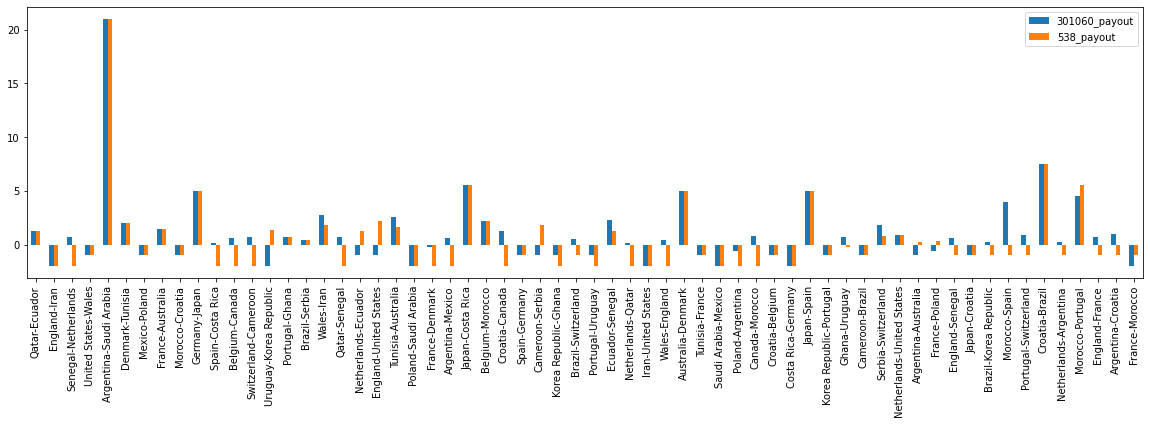

In [12]:
fig, ax = plt.subplots(figsize=(20, 5))
payouts.plot.bar(ax=ax)
fig.patch.set_facecolor('white')
ax.set_xticklabels(payouts['match']);

In [17]:
for row in payouts[['match', '301060_payout', '538_payout']].to_dict('records'):
    print(f"{row['match']}: {row['301060_payout']:.2f} (301060) {row['538_payout']:.2f} (fivethirtyeight)")

Qatar-Ecuador: 1.25 (301060) 1.25 (fivethirtyeight)
England-Iran: -2.00 (301060) -2.00 (fivethirtyeight)
Senegal-Netherlands: 0.66 (301060) -2.00 (fivethirtyeight)
United States-Wales: -1.00 (301060) -1.00 (fivethirtyeight)
Argentina-Saudi Arabia: 21.00 (301060) 21.00 (fivethirtyeight)
Denmark-Tunisia: 2.00 (301060) 2.00 (fivethirtyeight)
Mexico-Poland: -1.00 (301060) -1.00 (fivethirtyeight)
France-Australia: 1.45 (301060) 1.45 (fivethirtyeight)
Morocco-Croatia: -1.00 (301060) -1.00 (fivethirtyeight)
Germany-Japan: 5.00 (301060) 5.00 (fivethirtyeight)
Spain-Costa Rica: 0.14 (301060) -2.00 (fivethirtyeight)
Belgium-Canada: 0.60 (301060) -2.00 (fivethirtyeight)
Switzerland-Cameroon: 0.75 (301060) -2.00 (fivethirtyeight)
Uruguay-Korea Republic: -2.00 (301060) 1.40 (fivethirtyeight)
Portugal-Ghana: 0.75 (301060) 0.75 (fivethirtyeight)
Brazil-Serbia: 0.44 (301060) 0.44 (fivethirtyeight)
Wales-Iran: 2.80 (301060) 1.80 (fivethirtyeight)
Qatar-Senegal: 0.70 (301060) -2.00 (fivethirtyeight)
Net